## Import 

In [1]:
import os 
import matplotlib.pyplot as plt
import lam_adapt
import numpy as np

## Set up model
- The model can be loaded in using the library's unpack_model() function
- The model will take in an object of the input_data class to assemble an input torch.Tensor automatically. It is also possible for the user to this manually though

In [5]:
# Set up model
use_gpu = False # set to true if using GPU to accelerate prediction
os.chdir('C:/Users/leeho/OneDrive/바탕 화면/local') # set this to file location 
model, likelihood = lam_adapt.unpack_model(use_gpu=use_gpu) # load in the model
# may require download if you don't have the lam_L.pt file (6.1 GB)

# Prepare for prediction 
demo_num_points_per_surface = 120 # how many points over each surface? increasing this will require longer time
# parameters required to define an input class 
input_airfoil = './airfoil_coordinates/SC 1095_coordinates.csv' # can be a coordinates CSV file
# input_airfoil = 'NACA 0012' # can also be a NACA 4-digit or 5-digit airfoil
angle_of_attack = 6.0 # degrees
mach_number = 0.6 # freestream mach number
test_airfoil = lam_adapt.input_data('./airfoil_coordinates/SC 1095_coordinates.csv', angle_of_attack, mach_number, demo_num_points_per_surface, use_gpu=use_gpu)

Loading in model...
    lam_L.pt file already loaded...
    Loading complete!


## Generate predictions
- predictions are generating by feeding the input data class through the model's predict() method
- the output is a dict object that contains:
    1. cp_distribution: model posterior predictive distribution | gpytorch.distributions.MultivariateNormal
    2. xc: x/c location for cp_distribution, mostly for plotting | torch.Tensor
    3. 'cX_mean': coefficient, mean
    4. 'cX_stdev': coefficient, standard deviation

In [6]:
predictions = model.predict(test_airfoil, get_coeff=True)

## Visualize predictions
A code snippet demonstrating how to use the prediction dict to visualize the posterior prediction

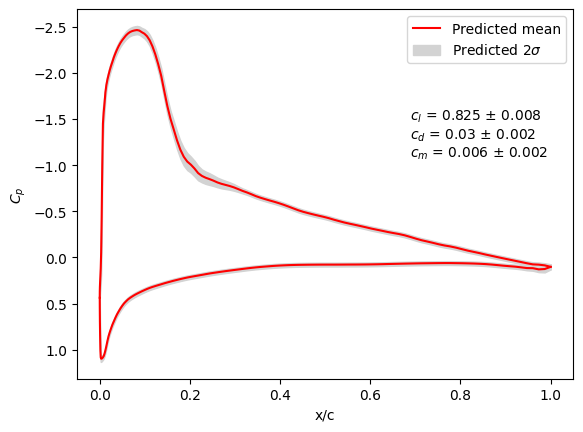

In [7]:
# get prediction mean and standard deviation
prediction_mean = predictions['cp_distribution'].mean.cpu().detach().numpy()
prediction_sig = np.sqrt(np.diag(predictions['cp_distribution'].covariance_matrix.cpu().detach().numpy()))

# organize into upper and lower surfaces for plotting 
f, ax = plt.subplots()
test_xcu, test_xcl = predictions['xc'][:demo_num_points_per_surface], predictions['xc'][demo_num_points_per_surface:] # x/c
test_cpu, test_cpl = prediction_mean[:demo_num_points_per_surface], prediction_mean[demo_num_points_per_surface:] # C_p
test_2sigu, test_2sigl = 2*prediction_sig[:demo_num_points_per_surface], 2*prediction_sig[demo_num_points_per_surface:] # 2 sigma in C_p
plt.plot(test_xcu, test_cpu, 'r-', label='Predicted mean')
plt.plot(test_xcl, test_cpl, 'r-')
plt.fill_between(test_xcu, test_cpu-test_2sigu, test_cpu+test_2sigu, color='lightgray', label='Predicted 2$\sigma$')
plt.fill_between(test_xcl, test_cpl-test_2sigl, test_cpl+test_2sigl, color='lightgray')
plt.xlabel('x/c')
plt.ylabel('$C_p$')
plt.gca().invert_yaxis()
plt.legend()
plt.text(0.67, 0.7, '$c_l$ = ' + str(np.round(predictions['cl_mean'], 3)) + ' $\pm$ ' + str(np.round(2*predictions['cl_stdev'], 3)), transform=ax.transAxes)
plt.text(0.67, 0.65, '$c_d$ = ' + str(np.round(predictions['cd_mean'], 3)) + ' $\pm$ ' + str(np.round(2*predictions['cd_stdev'], 3)), transform=ax.transAxes)
plt.text(0.67, 0.6, '$c_m$ = ' + str(np.round(predictions['cm_mean'], 3)) + ' $\pm$ ' + str(np.round(2*predictions['cm_stdev'], 3)), transform=ax.transAxes)
plt.show() 
